<a href="https://colab.research.google.com/github/roberthsheng/100pgml/blob/main/mflr_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-feature Linear Regression

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
np.random.seed(42)
N = 100
X = np.random.randn(N, 3)
true_w = np.array([2.0, -1.0, 0.5])
true_b = 3.0
y = X @ true_w + true_b + np.random.randn(N) * 0.1

In [4]:
def matrix_mse(X, y, w, b):
  return np.mean((X @ w + b - y) ** 2)

def matrix_grad(X, y, w, b):
  N = X.shape[0]
  error = X @ w + b - y
  grad_w = 2 * (X.T @ error) / N
  grad_b = 2 * np.mean(error)
  return grad_w, grad_b

def train(X, y, lr, epochs):
  N, D = X.shape
  w = np.zeros(D)
  b = 0.0
  losses = []
  for epoch in range(epochs):
    loss = matrix_mse(X, y, w, b)
    losses.append(loss)
    grad_w, grad_b = matrix_grad(X, y, w, b)
    w -= lr * grad_w
    b -= lr * grad_b
  return w, b, losses

Learned weights: [ 1.99223008 -1.00499694  0.48923982]
True weights: [ 2.  -1.   0.5]
Learned bias: 3.011286965363195
True bias: 3.0


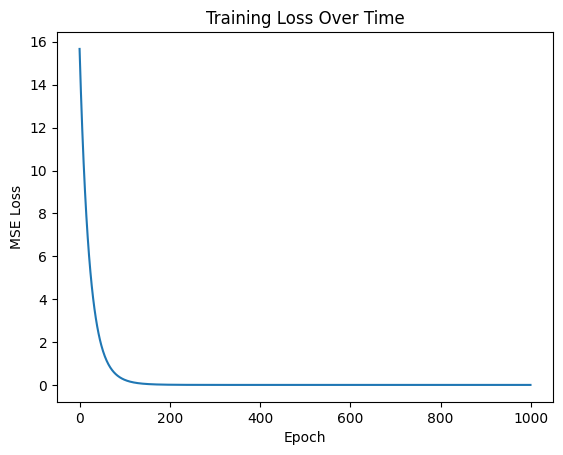

In [5]:
lr = 0.01
epochs = 1000
w, b, losses = train(X, y, lr, epochs)

print("Learned weights:", w)
print("True weights:", true_w)
print("Learned bias:", b)
print("True bias:", true_b)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.show()

In [8]:
def matrix_mse_reg(X, y, w, b, reg):
  return np.mean((X @ w + b - y) ** 2) + reg * np.sum(w ** 2)

def matrix_grad_reg(X, y, w, b, reg):
  N = X.shape[0]
  error = X @ w + b - y
  grad_w = 2 * (X.T @ error) / N + 2 * reg * w
  grad_b = 2 * np.mean(error)
  return grad_w, grad_b

def train_reg(X, y, lr, epochs, reg):
  N, D = X.shape
  w = np.zeros(D)
  b = 0
  losses = []
  for epoch in range(epochs):
    loss = matrix_mse_reg(X, y, w, b, reg)
    losses.append(loss)
    grad_w, grad_b = matrix_grad
    w -= lr * grad_w
    b -= lr * grad_b
  return w, b, losses

def train_minibatch(X, y, lr, epochs, batch_size=32, reg=0.1):
  N, D = X.shape
  w = np.zeros(D)
  b = 0
  losses = []
  for epoch in range(epochs):
    indices = np.random.permutation(N)
    X = X[indices]
    y = y[indices]
    for i in range(0, N, batch_size):
      X_batch = X[i:i+batch_size]
      y_batch = y[i:i+batch_size]
      grad_w, grad_b = matrix_grad_reg(X_batch, y_batch, w, b, reg)
      w -= lr * grad_w
      b -= lr * grad_b
    loss = matrix_mse_reg(X, y, w, b, reg)
    losses.append(loss)

  return w, b, losses

def train_with_early_stopping(X, y, X_val, y_val, lr, epochs, patience=5, batch_size=32):
    N, D = X.shape
    w = np.zeros(D)
    b = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    best_w, best_b = w, b

    for epoch in range(epochs):
        w, b, _ = train_minibatch(X, y, lr, 1, batch_size)

        val_loss = matrix_mse(X_val, y_val, w, b)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_w, best_b = w, b
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_w, best_b

In [9]:
np.random.seed(42)
N_train = 1000
N_val = 200
X_train = np.random.randn(N_train, 3)
X_val = np.random.randn(N_val, 3)
true_w = np.array([2.0, -1.0, 0.5])
true_b = 3.0

y_train = X_train @ true_w + true_b + np.random.randn(N_train) * 0.5
y_val = X_val @ true_w + true_b + np.random.randn(N_val) * 0.5

# Comparing batch sizes
batch_sizes = [1, 32, 128, N_train]  # last one is full batch
for batch_size in batch_sizes:
    start_time = time.time()
    w, b, losses = train_minibatch(X_train, y_train, lr=0.01, epochs=100,
                                  batch_size=batch_size)
    time_taken = time.time() - start_time
    final_loss = losses[-1]
    print(f"Batch size {batch_size}: Time = {time_taken:.2f}s, Final loss = {final_loss:.4f}")

# Early stopping vs no early stopping
print("\nWith Early Stopping:")
w_early, b_early = train_with_early_stopping(X_train, y_train, X_val, y_val,
                                           lr=0.01, epochs=1000, patience=5)

print("\nWithout Early Stopping:")
w_full, b_full = train_minibatch(X_train, y_train, lr=0.01, epochs=1000)[:2]

# Comparing validation performance
val_loss_early = matrix_mse(X_val, y_val, w_early, b_early)
val_loss_full = matrix_mse(X_val, y_val, w_full, b_full)
print(f"Validation Loss with early stopping: {val_loss_early:.4f}")
print(f"Validation Loss without early stopping: {val_loss_full:.4f}")

# Production-style training
def production_training(X_train, y_train, X_val, y_val):
    return train_with_early_stopping(
        X_train, y_train, X_val, y_val,
        lr=0.01,
        epochs=1000,
        patience=5,
        batch_size=32
    )

w_prod, b_prod = production_training(X_train, y_train, X_val, y_val)
print("\nProduction model performance:")
print("Train loss:", matrix_mse(X_train, y_train, w_prod, b_prod))
print("Val loss:", matrix_mse(X_val, y_val, w_prod, b_prod))
print("Learned weights:", w_prod)
print("True weights:", true_w)

Batch size 1: Time = 2.27s, Final loss = 0.7414
Batch size 32: Time = 0.09s, Final loss = 0.7200
Batch size 128: Time = 0.03s, Final loss = 0.7199
Batch size 1000: Time = 0.01s, Final loss = 0.9026

With Early Stopping:
Early stopping at epoch 12

Without Early Stopping:
Validation Loss with early stopping: 3.9813
Validation Loss without early stopping: 0.3224
Early stopping at epoch 10

Production model performance:
Train loss: 4.082712630162875
Val loss: 4.0479090813859155
Learned weights: [ 0.96769847 -0.49778351  0.24485234]
True weights: [ 2.  -1.   0.5]


Logistic Regression

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2733
Epoch 200, Loss: 0.2088
Epoch 300, Loss: 0.1790
Epoch 400, Loss: 0.1607
Epoch 500, Loss: 0.1479
Epoch 600, Loss: 0.1383
Epoch 700, Loss: 0.1307
Epoch 800, Loss: 0.1245
Epoch 900, Loss: 0.1192


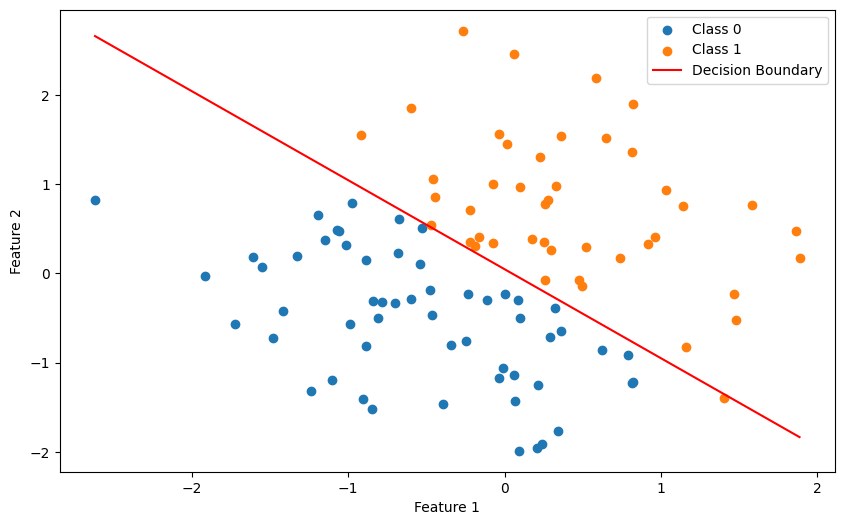

In [10]:
np.random.seed(42)
N = 100
X = np.random.randn(N, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(float)

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def forward(X, w, b):
  return sigmoid(X @ w + b)

def BCE(y_true, y_pred):
  return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def gradients(X, y, y_pred):
  m = X.shape[0]
  dw = (1 / m) * X.T @ (y_pred - y)
  db = (1 / m) * np.sum(y_pred - y)
  return dw, db

def train_logistic(X, y, lr=0.1, epochs=1000):
  N, D = X.shape
  w = np.zeros(D)
  b = 0.0
  losses = []
  for epoch in range(epochs):
    y_pred = forward(X, w, b)
    loss = BCE(y, y_pred)
    losses.append(loss)
    dw, db = gradients(X, y, y_pred)
    w -= lr * dw
    b -= lr * db
    if epoch % 100 == 0:
      print(f"Epoch {epoch}, Loss: {loss:.4f}")
  return w, b, losses

w, b, losses = train_logistic(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label='Class 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label='Class 1')

x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2 = -(w[0] * x1 + b) / w[1]
plt.plot(x1, x2, 'r-', label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()